In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [ ]:
def load_datasets(datasets):
  uploaded = files.upload()
  dataframes = {}
  for key, value in datasets.items():
    try:
      dataframes[key] = pd.read_csv(value, encoding='utf-8-sig')
    except FileNotFoundError:
      print(f"Error: File '{value}' not found. Skipping.")
  return dataframes

In [ ]:
def combine_dataframes(dataframes):
  combined_df = pd.DataFrame()
  for df in dataframes.values():
    df = df.drop(columns=['Unnamed: 0'])
    df['metric'] = df['metric'].replace({
    'f1 score': 'F1-Score',
    'balanced accuracy': 'Balanced Accuracy'
  })
    combined_df = pd.concat([combined_df, df], ignore_index=True)

    combined_df['scenario_id'] = (
        combined_df['scenario']
        .apply(lambda x: 1 if x == 'Scenario 1: standard' else 2)
    )

    combined_df['model'] = combined_df['dataset'].str.split('_').str[0]
    combined_df['model'] = combined_df['model'].str.rstrip('2').str.upper()
    combined_df['imputation'] = (
        combined_df['dataset'].str.endswith('_mf')
        .apply(lambda x: 'mf' if x else 'simple')
    )

  return combined_df

In [ ]:
def aggregate_performances_from_seeds(df, agg_cols, metric_cols, agg_functions):
  agg_df = df.groupby(agg_cols)[metric_cols].agg(agg_functions).reset_index()
  agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
  agg_df.columns = [col[:-1] if col.endswith('_') else col for col in agg_df.columns]
  return agg_df

In [ ]:
def plot_performance_decay_single_scenario(df, metric_name, x_colname, scenario_id):
    if scenario_id not in df['scenario_id'].unique():
        print(
            f"Warning: scenario_id must be 1 (standard) or 2 (drop intercorrelated)"
        )
        return

    if metric_name not in df['metric'].unique():
        print(
            f"Warning: metric_name must be 'F1-score' or 'Balanced Accuracy'"
        )
        return

    plot_df = df[df['scenario_id'] == scenario_id]
    plot_df = plot_df[plot_df['metric'] == metric_name]
    metric_colname = "f1_score_mean" if metric_name == 'F1-Score' else "balanced_accuracy_mean"
    scenario_name = "Scenario Standard" if scenario_id == 1 else "Scenario Drop Intercorrelated"

    # Adjust figure size and add space at bottom for legend
    # plt.figure(figsize=(12, 4))
    plt.figure(figsize=(9, 3.5))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
    models_list = np.sort(plot_df['model'].unique())

    # Create lines for the plot and legend handles
    lines = []
    i=0
    for model in models_list:
        for imputation in ['simple', 'mf']:
            model_df = plot_df[(plot_df['model'] == model) & (plot_df['imputation'] == imputation)]
            if imputation == "simple":
                line, = plt.plot(model_df[x_colname], model_df[metric_colname],
                               color=colors[i], linestyle='-')
            else:
                line, = plt.plot(model_df[x_colname], model_df[metric_colname],
                               color=colors[i], linestyle='--')
        lines.append(line)
        i = i+1

    plt.xlabel('Number of Disrupted Features', fontsize=10)
    plt.ylabel(metric_name, fontsize=10)
    plt.title(f'{scenario_name}: {metric_name} decline for different models')
    plt.xticks(range(0, 21))
    plt.xlim(0, 20)

    # Create custom legend handles for models
    legend_elements = [Line2D([0], [0], color=colors[i], label=model)
                      for i, model in enumerate(models_list)]

    # Add custom legend handles for imputation types
    legend_elements.extend([
        Line2D([0], [0], color='gray', linestyle='-', label='Simple Imputation'),
        Line2D([0], [0], color='gray', linestyle='--', label='MissForest Imputation')
    ])

    # Create legend at the bottom
    plt.legend(handles=legend_elements,
              bbox_to_anchor=(0.5, -0.2),
              loc='upper center',
              borderaxespad=0.,
              fontsize=10,
              ncol=len(models_list) + 2)

    plt.grid(True)
    # Adjust layout to make room for legend at bottom
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Add space at bottom for legend
    plt.show()


In [ ]:
def compare_scenarios(df, metric_name):
    models_list = np.sort(df['model'].unique())
    df = df[df['metric'] == metric_name]
    scenario1_df = df[df['scenario_id'] == 1]
    scenario2_df = df[df['scenario_id'] == 2]
    metric_colname = "f1_score_mean" if metric_name == 'F1-Score' else "balanced_accuracy_mean"
    scenario_labels = ["Scenario Standard", "Scenario Drop Intercorrelated"]

    # Create subplots in a 2x4 grid
    fig, axes = plt.subplots(2, 4, figsize=(15, 6), sharey=True)
    axes = axes.flatten()

    colors = ['#1f77b4', '#ff7f0e']
    lines = []
    labels = []

    for ax_index, model in enumerate(models_list):
        model_scenario1 = scenario1_df[(scenario1_df['model'] == model) & (scenario1_df['imputation'] == 'simple')]
        model_scenario2 = scenario2_df[(scenario2_df['model'] == model) & (scenario2_df['imputation'] == 'simple')]
        model_scenario1_mf = scenario1_df[(scenario1_df['model'] == model) & (scenario1_df['imputation'] == 'mf')]
        model_scenario2_mf = scenario2_df[(scenario2_df['model'] == model) & (scenario2_df['imputation'] == 'mf')]

        # Store lines and labels only from the first subplot
        if ax_index == 0:
            line1, = axes[ax_index].plot(model_scenario1['num_feat_missing'], model_scenario1[metric_colname],
                                       label=f"{scenario_labels[0]} (Simple)", color=colors[0])
            line2, = axes[ax_index].plot(model_scenario2['num_feat_missing'], model_scenario2[metric_colname],
                                       label=f"{scenario_labels[1]} (Simple)", color=colors[1])
            line3, = axes[ax_index].plot(model_scenario1_mf['num_feat_missing'], model_scenario1_mf[metric_colname],
                                       label=f"{scenario_labels[0]} (MissForest)", color=colors[0], linestyle='--')
            line4, = axes[ax_index].plot(model_scenario2_mf['num_feat_missing'], model_scenario2_mf[metric_colname],
                                       label=f"{scenario_labels[1]} (MissForest)", color=colors[1], linestyle='--')
            lines = [line1, line2, line3, line4]
        else:
            axes[ax_index].plot(model_scenario1['num_feat_missing'], model_scenario1[metric_colname],
                              color=colors[0])
            axes[ax_index].plot(model_scenario2['num_feat_missing'], model_scenario2[metric_colname],
                              color=colors[1])
            axes[ax_index].plot(model_scenario1_mf['num_feat_missing'], model_scenario1_mf[metric_colname],
                              color=colors[0], linestyle='--')
            axes[ax_index].plot(model_scenario2_mf['num_feat_missing'], model_scenario2_mf[metric_colname],
                              color=colors[1], linestyle='--')

        axes[ax_index].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        axes[ax_index].set_xlim(0, 20)
        axes[ax_index].set_xlabel('Number of features disrupted')
        axes[ax_index].set_ylabel(metric_name)
        axes[ax_index].set_title(f'{model}')

    # Hide unused subplots
    for i in range(len(models_list), len(axes)):
        axes[i].axis('off')

    # Add single legend at the bottom
    fig.legend(lines, [line.get_label() for line in lines],
              loc='center', bbox_to_anchor=(0.5, 0.02),
              ncol=4)

    plt.subplots_adjust(hspace=0.4, bottom=0.14)  # Adjusted bottom margin for legend
    plt.show()

In [ ]:
def compare_scenarios_old(df, metric_name):
  models_list = np.sort(df['model'].unique())
  df = df[df['metric'] == metric_name]
  scenario1_df = df[df['scenario_id'] == 1]
  scenario2_df = df[df['scenario_id'] == 2]
  metric_colname = "f1_score_mean" if metric_name == 'f1 score' else "balanced_accuracy_mean"
  scenario_labels = ["Scenario Standard", "Scenario Drop Intercorrelated"]


  nr_subplots = len(models_list)

  # Create subplots
  fig, axes = plt.subplots(nr_subplots, 1, figsize=(10, nr_subplots * 6), sharey=True)

  # Keep track of current axis index
  ax_index = 0
  colors = ['#1f77b4', '#ff7f0e']
  for model in models_list:
    model_scenario1 = scenario1_df[(scenario1_df['model'] == model) & (scenario1_df['imputation'] == 'simple')]
    model_scenario2 = scenario2_df[(scenario2_df['model'] == model) & (scenario2_df['imputation'] == 'simple')]
    model_scenario1_mf = scenario1_df[(scenario1_df['model'] == model) & (scenario1_df['imputation'] == 'mf')]
    model_scenario2_mf = scenario2_df[(scenario2_df['model'] == model) & (scenario2_df['imputation'] == 'mf')]

    # Plotting on the current subplot
    axes[ax_index].plot(model_scenario1['num_feat_missing'], model_scenario1[metric_colname], label=scenario_labels[0]+' (simple)', color=colors[0])
    axes[ax_index].plot(model_scenario2['num_feat_missing'], model_scenario2[metric_colname], label=scenario_labels[1]+' (simple)', color=colors[1])
    axes[ax_index].plot(model_scenario1_mf['num_feat_missing'], model_scenario1_mf[metric_colname], label=scenario_labels[0]+' (mf)', color=colors[0], linestyle='--')
    axes[ax_index].plot(model_scenario2_mf['num_feat_missing'], model_scenario2_mf[metric_colname],  label=scenario_labels[1]+' (mf)', color=colors[1], linestyle='--')
    axes[ax_index].set_xlim(0, 20)
    axes[ax_index].set_xlabel(f'Number of features disrupted')
    axes[ax_index].set_ylabel(f'{metric_name}')
    axes[ax_index].set_title(f'{model} - {metric_name}')
    axes[ax_index].legend(loc='lower center',  bbox_to_anchor=(0.5, -0.35), ncol=2)

    # Move to the next subplot
    ax_index += 1

  plt.subplots_adjust(hspace=0.6)
  plt.show()

In [ ]:
def plot_performance_after_x_features_imputed(df, scenario_id, metric_name, num_feat_imputed_list):
  if metric_name not in df['metric'].unique():
    print(
        f"Warning: metric_name must be 'F1-Score' or 'Balanced Accuracy'"
    )
    return

  if scenario_id not in df['scenario_id'].unique():
    print(
        f"Warning: scenario_id must be 1 (standard) or 2 (drop intercorrelated)"
    )
    return

  scenario_name = "Scenario Standard" if scenario_id == 1 else "Scenario Drop Intercorrelated"
  metric_colname = "f1_score_mean" if metric_name == 'F1-Score' else "balanced_accuracy_mean"
  df = df[(df['metric'] == metric_name) & (df['scenario_id'] == scenario_id)]
  df_0_imputed = df[df['num_feat_missing'] == 0]

  num_plots = len(num_feat_imputed_list)
  fig, axes = plt.subplots(
      1, num_plots, figsize=(8 * num_plots, 6), sharey=True
  )

  # Check if axes is a single Axes object or an array
  if num_plots == 1:
    axes = [axes]

  # Create scatterplot for the first subplot to get legend handles and labels
  df_x_imputed = df[df['num_feat_missing'] == num_feat_imputed_list[0]]
  merged_df = pd.merge(df_0_imputed[['model', 'imputation', metric_colname]],
                      df_x_imputed[['model', 'imputation', metric_colname]],
                      on=['model', 'imputation'],
                      suffixes=('_base', f'_{num_feat_imputed_list[0]}_imputed'))

  scatter = sns.scatterplot(ax=axes[0], data=merged_df,
                            x=f'{metric_colname}_{num_feat_imputed_list[0]}_imputed',
                            y=f'{metric_colname}_base', hue='model', s=100,
                            style='imputation')

  # Get legend handles and labels
  handles, labels = scatter.get_legend_handles_labels()

  # Remove legend from the first subplot
  axes[0].get_legend().remove()

  # Create remaining scatterplots without legends
  for i, num_feat_imputed in enumerate(num_feat_imputed_list):
    df_x_imputed = df[df['num_feat_missing'] == num_feat_imputed]
    merged_df = pd.merge(df_0_imputed[['model', 'imputation', metric_colname]],
                        df_x_imputed[['model', 'imputation', metric_colname]],
                        on=['model', 'imputation'],
                        suffixes=('_base', f'_{num_feat_imputed}_imputed'))

    sns.scatterplot(ax=axes[i], data=merged_df,
                    x=f'{metric_colname}_{num_feat_imputed}_imputed',
                    y=f'{metric_colname}_base', hue='model',
                    style='imputation', legend=False, s=150)

    axes[i].set_xlabel(f'{metric_name} with {num_feat_imputed} disrupted features', fontsize=20)
    axes[i].set_ylabel(f'{metric_name} base', fontsize=20)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].set_title(f'{scenario_name}: {metric_name} base vs {num_feat_imputed} disrupted features', fontsize=14)
    axes[i].grid(True)

  # Create a single legend outside the subplots
  fig.legend(handles, labels, title="Model & Imputation", loc='lower center',
             bbox_to_anchor=(0.5, -0.2), ncol=12, fontsize=20)

  plt.tight_layout()
  plt.show()

In [ ]:
german_datasets = {
    'german_scenario1_seed_1981': 'german_credit_scenario1_seed_1981.csv',
    'german_scenario1_seed_2024': 'german_credit_scenario1_seed_2024.csv',
    'german_scenario1_seed_2025': 'german_credit_scenario1_seed_2025.csv'
}

taiwanese_datasets = {
    'taiwan_scenario1_seed_1981': 'taiwanese_bankruptcy_scenario1_seed_1981.csv',
    'taiwan_scenario1_seed_2024': 'taiwanese_bankruptcy_scenario1_seed_2024.csv',
    'taiwan_scenario1_seed_2025': 'taiwanese_bankruptcy_scenario1_seed_2025.csv',
    'taiwan_scenario2_seed_1981': 'taiwanese_bankruptcy_scenario2_seed_1981.csv',
    'taiwan_scenario2_seed_2024': 'taiwanese_bankruptcy_scenario2_seed_2024.csv',
    'taiwan_scenario2_seed_2025': 'taiwanese_bankruptcy_scenario2_seed_2025.csv',
}

default_cc_datasets = {
    'default_cc_scenario1_seed_1981': 'default_cc_scenario1_seed_1981.csv',
    'default_cc_scenario1_seed_2024': 'default_cc_scenario1_seed_2024.csv',
    'default_cc_scenario1_seed_2025': 'default_cc_scenario1_seed_2025.csv',
    'default_cc_scenario2_seed_1981': 'default_cc_scenario2_seed_1981.csv',
    'default_cc_scenario2_seed_2024': 'default_cc_scenario2_seed_2024.csv',
    'default_cc_scenario2_seed_2025': 'default_cc_scenario2_seed_2025.csv'
}

default_cc_temp_datasets = {
    'default_cc_temp_scenario1_seed_1981': 'default_cc_temp_scenario1_seed_1981.csv',
    'default_cc_temp_scenario1_seed_2024': 'default_cc_temp_scenario1_seed_2024.csv',
    'default_cc_temp_scenario1_seed_2025': 'default_cc_temp_scenario1_seed_2025.csv',
    'default_cc_temp_scenario2_seed_1981': 'default_cc_temp_scenario2_seed_1981.csv',
    'default_cc_temp_scenario2_seed_2024': 'default_cc_temp_scenario2_seed_2024.csv',
    'default_cc_temp_scenario2_seed_2025': 'default_cc_temp_scenario2_seed_2025.csv'
}

dataframes = load_datasets(default_cc_datasets)

Saving default_cc_scenario1_seed_1981.csv to default_cc_scenario1_seed_1981.csv
Saving default_cc_scenario1_seed_2024.csv to default_cc_scenario1_seed_2024.csv
Saving default_cc_scenario1_seed_2025.csv to default_cc_scenario1_seed_2025.csv
Saving default_cc_scenario2_seed_1981.csv to default_cc_scenario2_seed_1981.csv
Saving default_cc_scenario2_seed_2024.csv to default_cc_scenario2_seed_2024.csv
Saving default_cc_scenario2_seed_2025.csv to default_cc_scenario2_seed_2025.csv


In [ ]:
dataframes['default_cc_scenario1_seed_1981']

,Unnamed: 0,tp,tn,fp,fn,precision,recall,specificity,accuracy,f1_score,balanced_accuracy,num_feat_missing,imputed,dataset,source,scenario,random_state,metric
0,0,807,3879,794,520,50.41,60.81,83.01,78.10,55.12,71.91,0,NaN,lr_perf,Default Credit Card,Scenario 1: standard,1981,f1 score
1,1,482,4257,416,845,53.67,36.32,91.10,78.98,43.33,63.71,1,['PAY_DELAY_1M_AGO'] imputed,lr_perf,Default Credit Card,Scenario 1: standard,1981,f1 score
2,2,444,4288,385,883,53.56,33.46,91.76,78.87,41.19,62.61,2,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed",lr_perf,Default Credit Card,Scenario 1: standard,1981,f1 score
3,3,332,4383,290,995,53.38,25.02,93.79,78.58,34.07,59.41,3,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...",lr_perf,Default Credit Card,Scenario 1: standard,1981,f1 score
4,4,306,4388,285,1021,51.78,23.06,93.90,78.23,31.91,58.48,4,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...",lr_perf,Default Credit Card,Scenario 1: standard,1981,f1 score
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,583,531,4241,432,796,55.14,40.02,90.76,79.53,46.38,65.39,16,"['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...",et2_perf_mf,Default Credit Card,Scenario 1: standard,1981,balanced accuracy
584,584,538,4230,443,789,54.84,40.54,90.52,79.47,46.62,65.53,17,"['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...",et2_perf_mf,Default Credit Card,Scenario 1: standard,1981,balanced accuracy
585,585,537,4236,437,790,55.13,40.47,90.65,79.55,46.68,65.56,18,"['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...",et2_perf_mf,Default Credit Card,Scenario 1: standard,1981,balanced accuracy
586,586,479,4375,298,848,61.65,36.10,93.62,80.90,45.53,64.86,19,"['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...",et2_perf_mf,Default Credit Card,Scenario 1: standard,1981,balanced accuracy


In [ ]:
combined_df = combine_dataframes(dataframes)
combined_df

,tp,tn,fp,fn,precision,recall,specificity,accuracy,f1_score,balanced_accuracy,num_feat_missing,imputed,dataset,source,scenario,random_state,metric,scenario_id,model,imputation
0,807,3879,794,520,50.41,60.81,83.01,78.10,55.12,71.91,0,NaN,lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
1,482,4257,416,845,53.67,36.32,91.10,78.98,43.33,63.71,1,['PAY_DELAY_1M_AGO'] imputed,lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
2,444,4288,385,883,53.56,33.46,91.76,78.87,41.19,62.61,2,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed",lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
3,332,4383,290,995,53.38,25.02,93.79,78.58,34.07,59.41,3,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...",lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
4,306,4388,285,1021,51.78,23.06,93.90,78.23,31.91,58.48,4,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...",lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,383,4315,358,944,51.69,28.86,92.34,78.30,37.04,60.60,16,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...",et2_perf_mf,Default Credit Card,Scenario 2: drop intercorrelated,2025,Balanced Accuracy,2,ET,mf
3524,385,4298,375,942,50.66,29.01,91.98,78.05,36.90,60.49,17,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...",et2_perf_mf,Default Credit Card,Scenario 2: drop intercorrelated,2025,Balanced Accuracy,2,ET,mf
3525,371,4342,331,956,52.85,27.96,92.92,78.55,36.57,60.44,18,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...",et2_perf_mf,Default Credit Card,Scenario 2: drop intercorrelated,2025,Balanced Accuracy,2,ET,mf
3526,304,4441,232,1023,56.72,22.91,95.04,79.08,32.64,58.97,19,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...",et2_perf_mf,Default Credit Card,Scenario 2: drop intercorrelated,2025,Balanced Accuracy,2,ET,mf


In [ ]:
agg_cols = ['source', 'model', 'imputation', 'scenario_id', 'scenario', 'metric', 'num_feat_missing']
metric_cols = ['f1_score', 'balanced_accuracy']
agg_functions = ['mean', 'std']
agg_df = aggregate_performances_from_seeds(combined_df, agg_cols, metric_cols, agg_functions)
agg_df

,source,model,imputation,scenario_id,scenario,metric,num_feat_missing,f1_score_mean,f1_score_std,balanced_accuracy_mean,balanced_accuracy_std
0,Default Credit Card,DT,mf,1,Scenario 1: standard,Balanced Accuracy,0,51.326667,0.395517,69.806667,0.646323
1,Default Credit Card,DT,mf,1,Scenario 1: standard,Balanced Accuracy,1,45.296667,2.424713,65.016667,1.737853
2,Default Credit Card,DT,mf,1,Scenario 1: standard,Balanced Accuracy,2,43.463333,4.644807,63.823333,3.025910
3,Default Credit Card,DT,mf,1,Scenario 1: standard,Balanced Accuracy,3,37.776667,14.780136,61.756667,6.738615
4,Default Credit Card,DT,mf,1,Scenario 1: standard,Balanced Accuracy,4,36.936667,16.178079,61.673333,6.878927
...,...,...,...,...,...,...,...,...,...,...,...
1171,Default Credit Card,XGB,simple,2,Scenario 2: drop intercorrelated,F1-Score,16,2.420000,4.191563,50.460000,0.796743
1172,Default Credit Card,XGB,simple,2,Scenario 2: drop intercorrelated,F1-Score,17,0.100000,0.173205,50.006667,0.011547
1173,Default Credit Card,XGB,simple,2,Scenario 2: drop intercorrelated,F1-Score,18,0.200000,0.346410,50.016667,0.028868
1174,Default Credit Card,XGB,simple,2,Scenario 2: drop intercorrelated,F1-Score,19,0.000000,0.000000,50.000000,0.000000


# **Metrics evolution**

## **F1 score**

*Sanity check of values*

In [ ]:
combined_df.head()

,tp,tn,fp,fn,precision,recall,specificity,accuracy,f1_score,balanced_accuracy,num_feat_missing,imputed,dataset,source,scenario,random_state,metric,scenario_id,model,imputation
0,807,3879,794,520,50.41,60.81,83.01,78.10,55.12,71.91,0,NaN,lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
1,482,4257,416,845,53.67,36.32,91.10,78.98,43.33,63.71,1,['PAY_DELAY_1M_AGO'] imputed,lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
2,444,4288,385,883,53.56,33.46,91.76,78.87,41.19,62.61,2,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed",lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
3,332,4383,290,995,53.38,25.02,93.79,78.58,34.07,59.41,3,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...",lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
4,306,4388,285,1021,51.78,23.06,93.90,78.23,31.91,58.48,4,"['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...",lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple


In [ ]:
combined_df['model'].unique()

array(['LR', 'SVM', 'DT', 'RF', 'GBT', 'XGB', 'ET'], dtype=object)

In [ ]:
cond1 = (combined_df['model'] == 'LR')
cond2 = (combined_df['scenario_id'] == 1)
cond3 = (combined_df['metric'] == 'F1-Score')
cond4 = (combined_df['num_feat_missing'] == 1)
combined_df[cond1 & cond2 & cond3 & cond4]

,tp,tn,fp,fn,precision,recall,specificity,accuracy,f1_score,balanced_accuracy,num_feat_missing,imputed,dataset,source,scenario,random_state,metric,scenario_id,model,imputation
1,482,4257,416,845,53.67,36.32,91.10,78.98,43.33,63.71,1,['PAY_DELAY_1M_AGO'] imputed,lr_perf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,simple
148,758,3811,862,569,46.79,57.12,81.55,76.15,51.44,69.34,1,['PAY_DELAY_1M_AGO'] imputed,lr_perf_mf,Default Credit Card,Scenario 1: standard,1981,F1-Score,1,LR,mf
589,485,4169,504,842,49.04,36.55,89.21,77.57,41.88,62.88,1,['PAY_DELAY_1M_AGO'] imputed,lr_perf,Default Credit Card,Scenario 1: standard,2024,F1-Score,1,LR,simple
736,699,3804,869,628,44.58,52.68,81.40,75.05,48.29,67.04,1,['PAY_DELAY_1M_AGO'] imputed,lr_perf_mf,Default Credit Card,Scenario 1: standard,2024,F1-Score,1,LR,mf
1177,480,4187,486,847,49.69,36.17,89.60,77.78,41.87,62.89,1,['PAY_DELAY_1M_AGO'] imputed,lr_perf,Default Credit Card,Scenario 1: standard,2025,F1-Score,1,LR,simple
1324,710,3726,947,617,42.85,53.50,79.73,73.93,47.59,66.62,1,['PAY_DELAY_1M_AGO'] imputed,lr_perf_mf,Default Credit Card,Scenario 1: standard,2025,F1-Score,1,LR,mf


In [ ]:
agg_df[(agg_df['scenario_id'] == 1) & (agg_df['metric'] == 'F1-Score') & (agg_df['num_feat_missing'] == 1) & (agg_df['model'] == 'LR')]

,source,model,imputation,scenario_id,scenario,metric,num_feat_missing,f1_score_mean,f1_score_std,balanced_accuracy_mean,balanced_accuracy_std
526,Default Credit Card,LR,mf,1,Scenario 1: standard,F1-Score,1,49.106667,2.050813,67.666667,1.464286
610,Default Credit Card,LR,simple,1,Scenario 1: standard,F1-Score,1,42.360000,0.840060,63.160000,0.476340


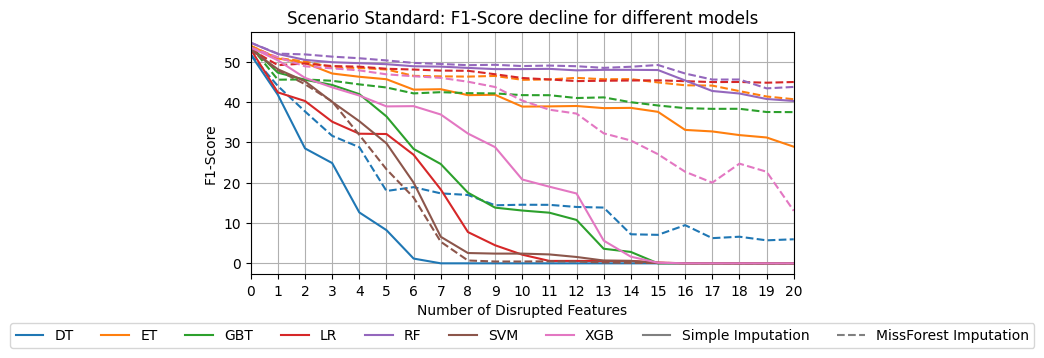

In [ ]:
plot_performance_decay_single_scenario(agg_df, 'F1-Score', 'num_feat_missing', 1)

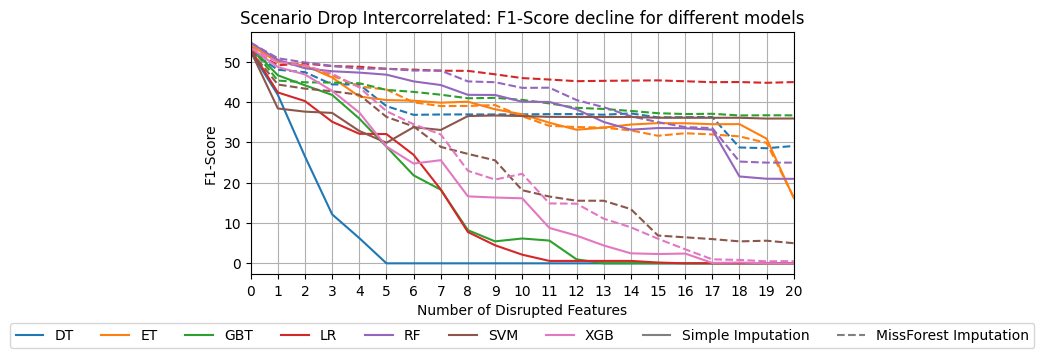

In [ ]:
plot_performance_decay_single_scenario(agg_df, 'F1-Score', 'num_feat_missing', 2)

## **Balanced accuracy**

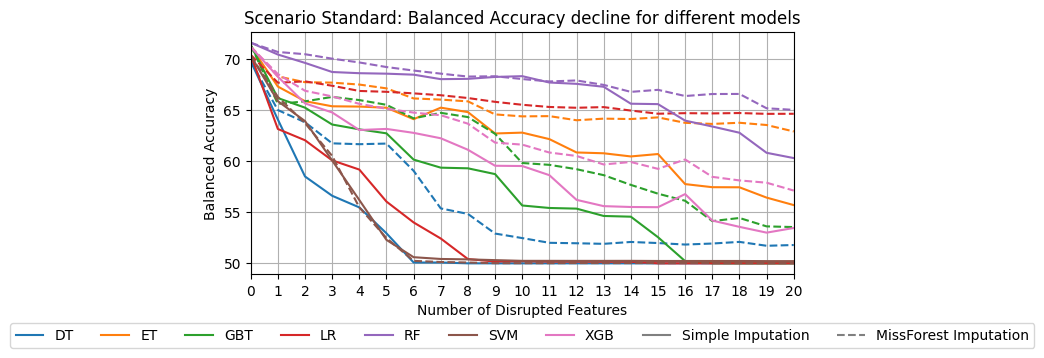

In [ ]:
plot_performance_decay_single_scenario(agg_df, 'Balanced Accuracy', 'num_feat_missing', 1)

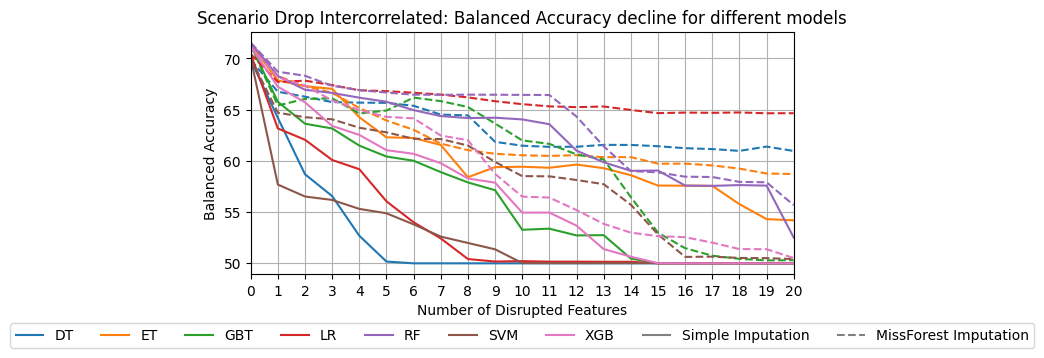

In [ ]:
plot_performance_decay_single_scenario(agg_df, 'Balanced Accuracy', 'num_feat_missing', 2)

# **Base performance vs Performance after disruption of x features**
Models on the top right of the plot are prefferable due to have initial high performance and maintain a high performance after disruption of several features

## **F1 score**

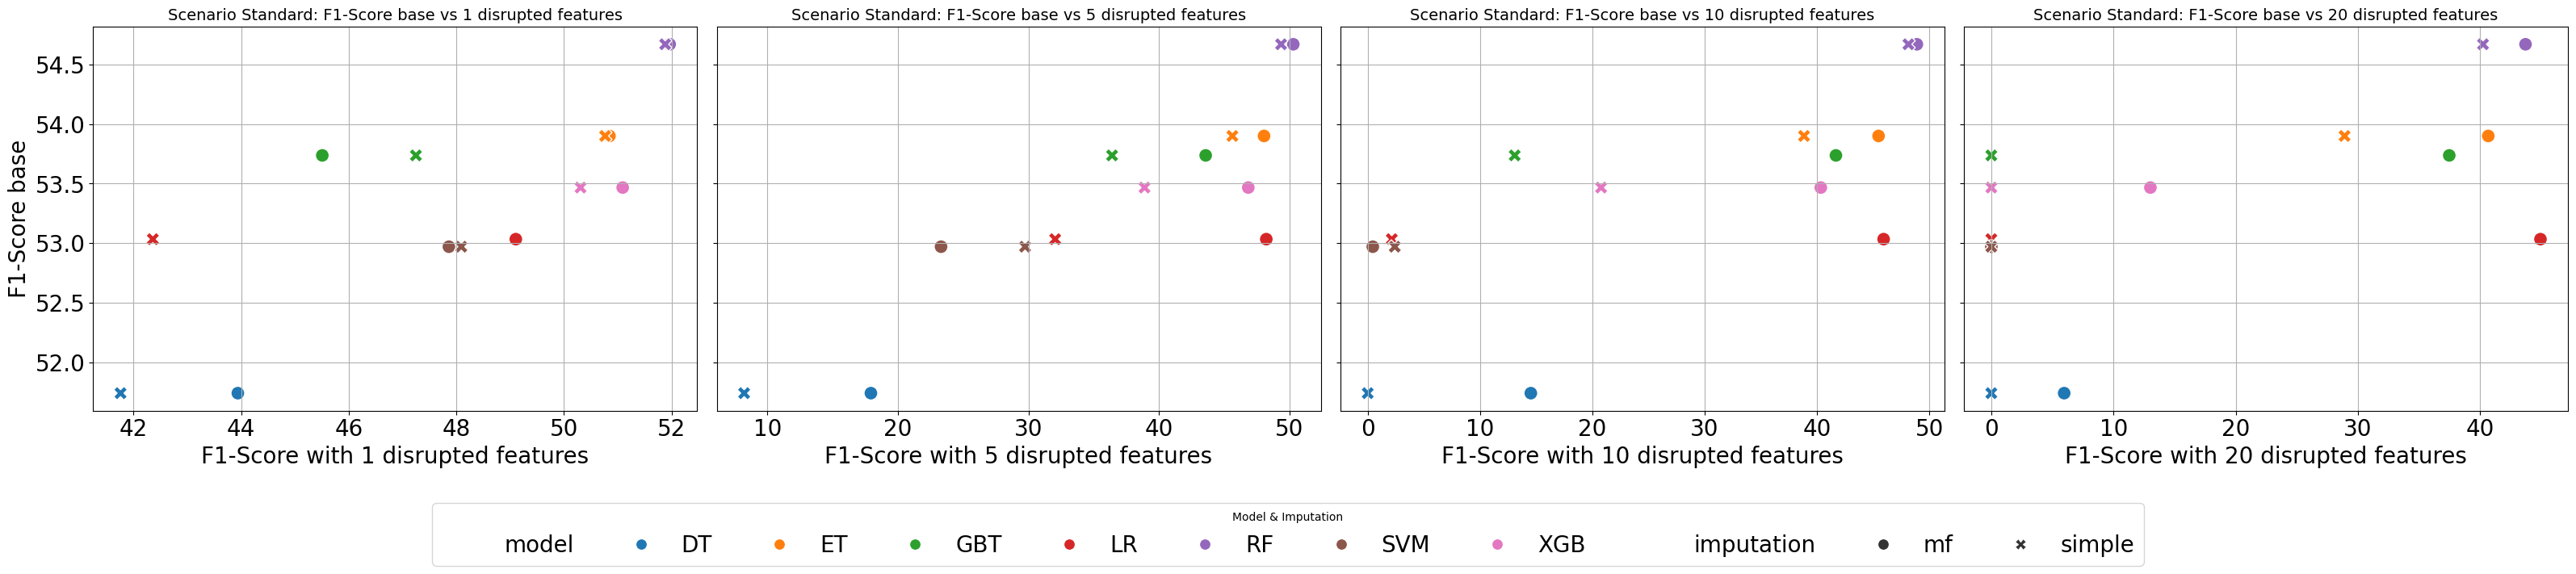

In [ ]:
plot_performance_after_x_features_imputed(agg_df, 1, 'F1-Score', [1, 5, 10, 20])

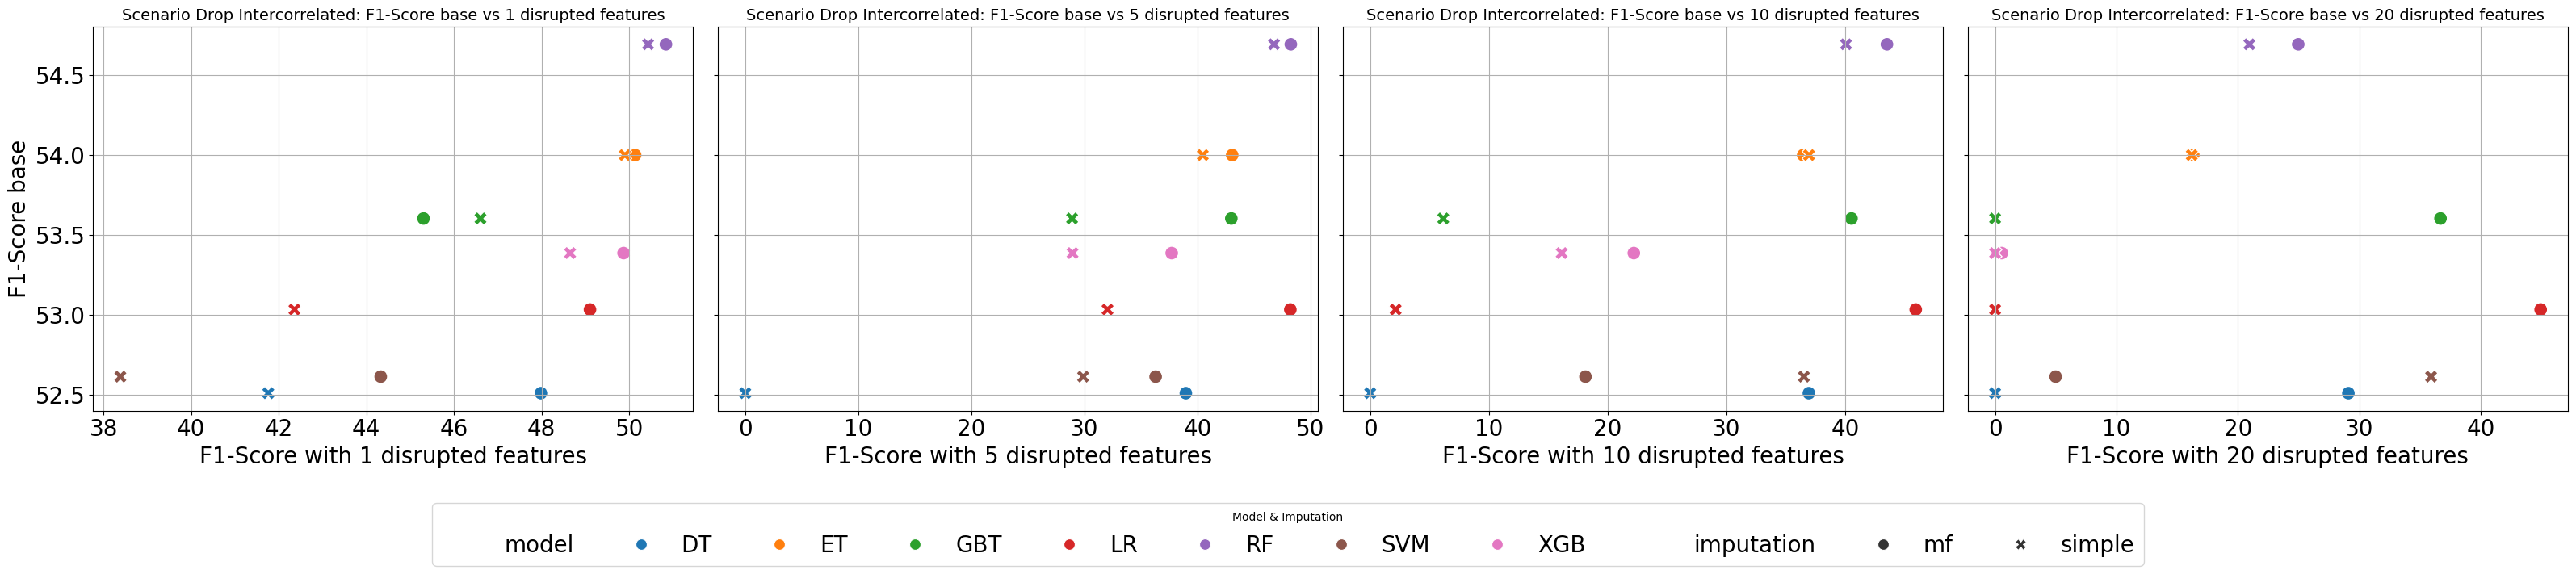

In [ ]:
plot_performance_after_x_features_imputed(agg_df, 2, 'F1-Score', [1, 5, 10, 20])

## **Balanced accuracy**

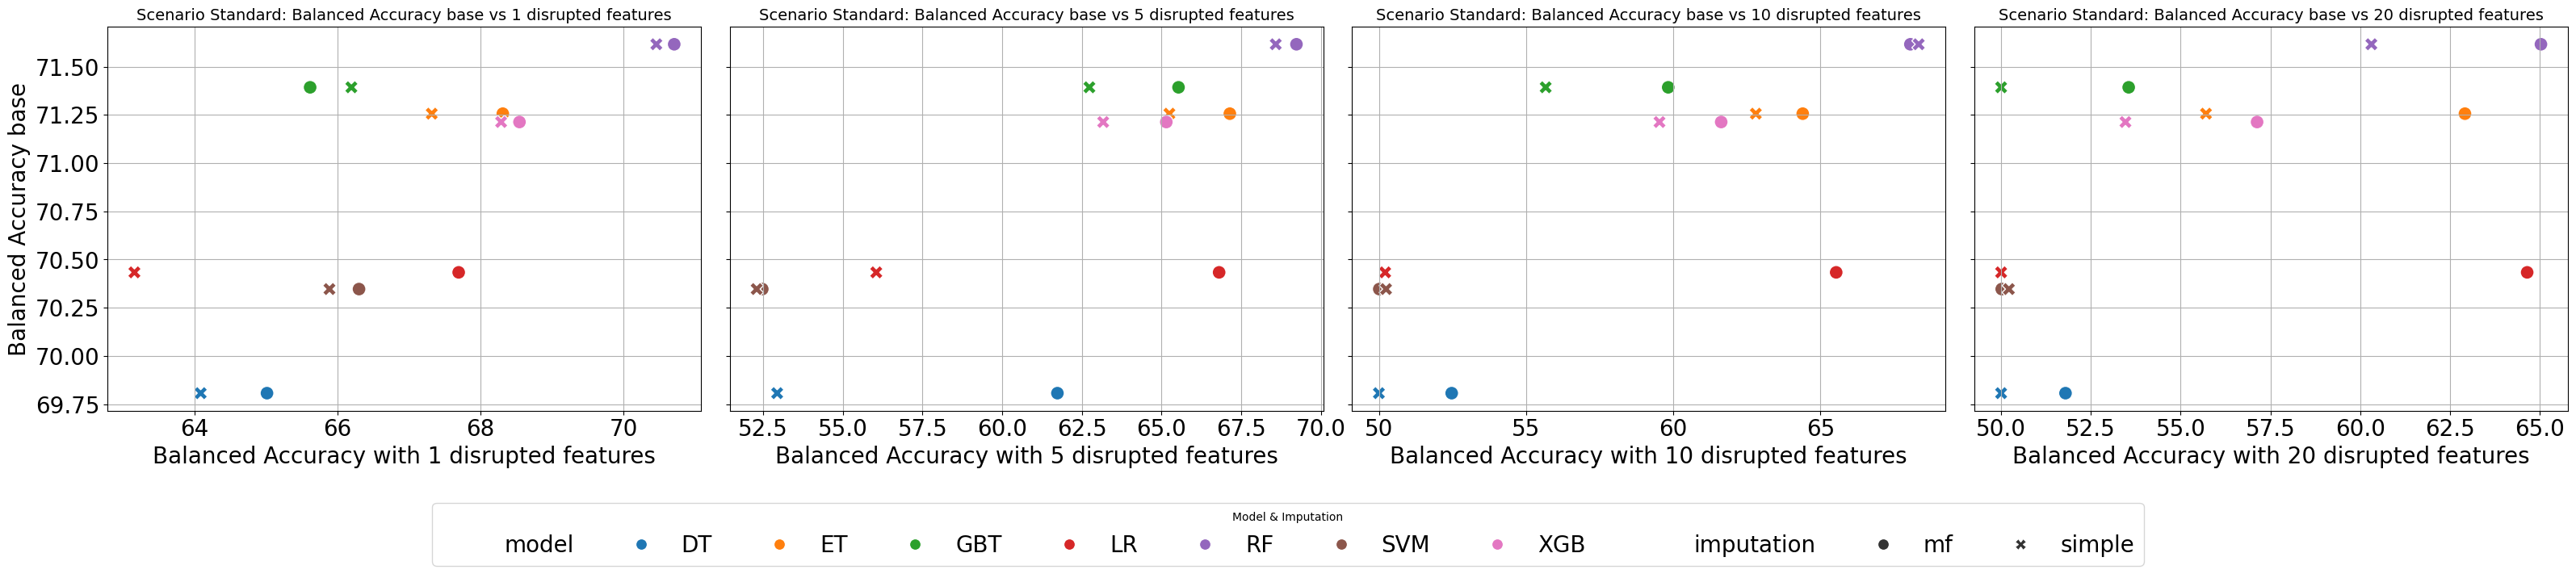

In [ ]:
plot_performance_after_x_features_imputed(agg_df, 1, 'Balanced Accuracy', [1, 5, 10, 20])

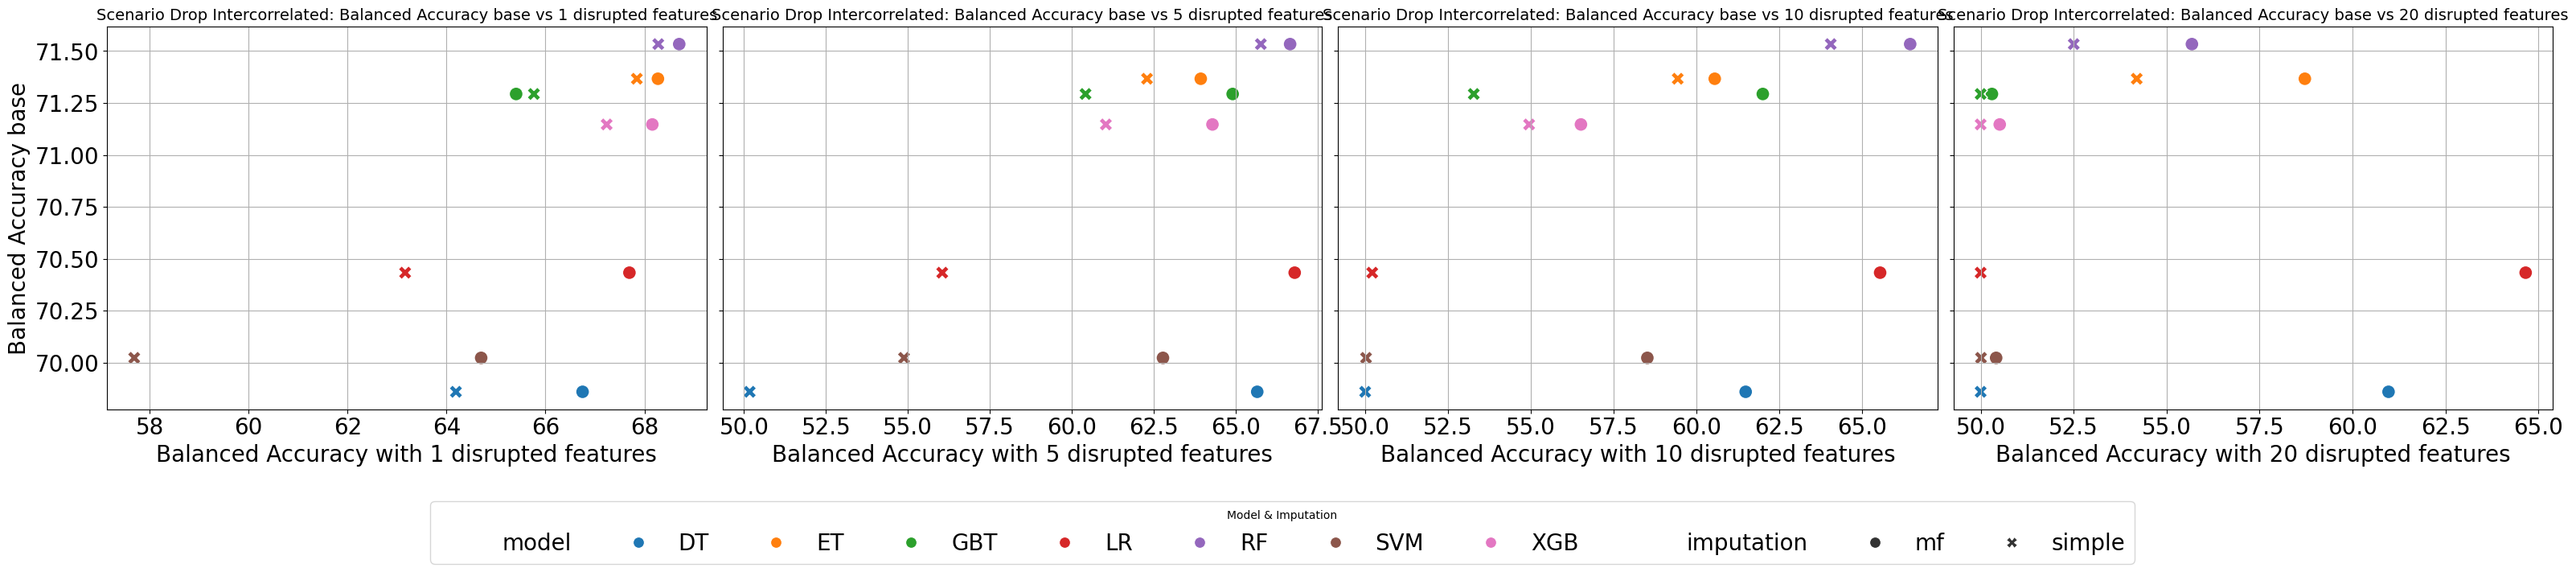

In [ ]:
plot_performance_after_x_features_imputed(agg_df, 2, 'Balanced Accuracy', [1, 5, 10, 20])

# **Comparison of scenarios**

## **F1 score**

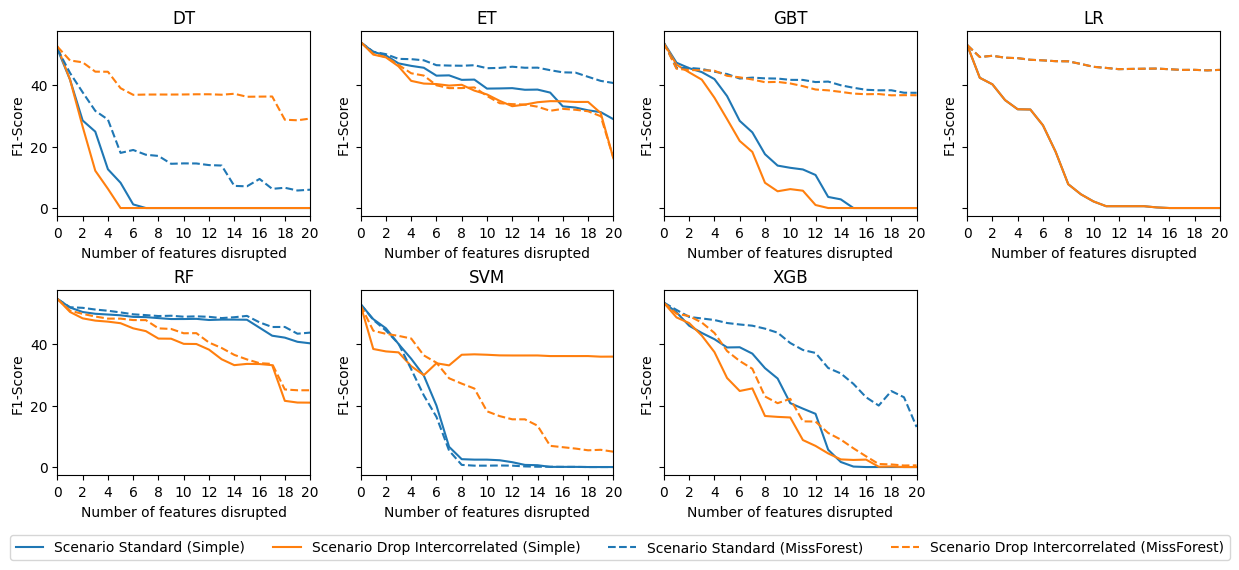

In [ ]:
compare_scenarios(agg_df, 'F1-Score')

## **Balanced accuracy**

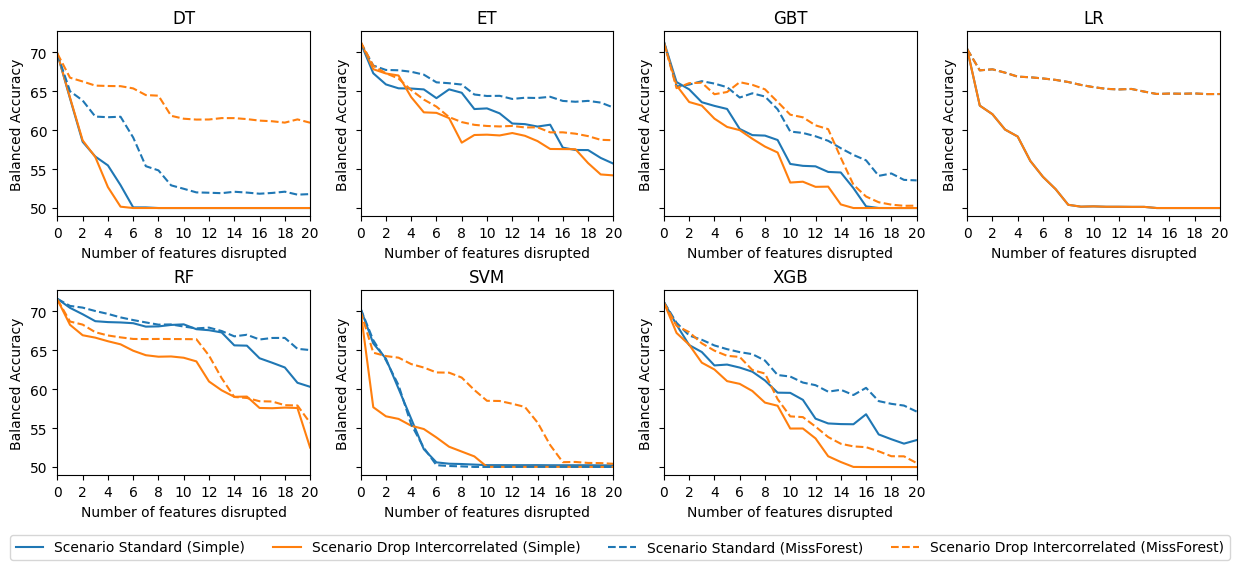

In [ ]:
compare_scenarios(agg_df, 'Balanced Accuracy')